In [1]:
import numpy as np
from MD_template import Potential
from MD_template import MD as MDTemplate
from MD_template import NoThermostat as NoThermTemplate
from MD_template import IsokinThermostat as IsoThermTemplate

import matplotlib.pyplot as plt
import matplotlib.animation as animation

EPSILON = 1
SIGMA = 1
H = 0.01
MASS = 1
rng = np.random.default_rng(seed=1337)

In [2]:
class LennardJones(Potential):
    def __init__(self, epsilon=EPSILON, sigma=SIGMA):
        self.epsilon = epsilon
        self.sigma = sigma
        self.sigma6 = self.sigma**6  # Trade memory for cpu cycles
        self.sigma12 = self.sigma**12  # Trade memory for cpu cycles

    def F(self, r, *args, **kwargs):
        norm = np.linalg.norm(r, axis=-1)[..., None]  # last axis is the x/y components
        return (
            48
            * self.epsilon
            * (
                self.sigma12 / norm**14 - 0.5 * self.sigma6 / norm**8
            )  # we divide by one power of r more to normalize the vector
            * r
        )

    def F2(self, r2, *args, **kwargs):
        # Force as a function of r^2
        return (
            48
            * self.epsilon
            * (self.sigma12 / r2**7 - 0.5 * self.sigma6 / r2**4)
            * np.sqrt(r2)
        )  # we divide by one power of r to much

    def V(self, r1, r2, *args, **kwargs):
        delta = r1 - r2
        r = np.linalg.norm(delta)
        return 4 * self.epsilon * (self.sigma12 / r**13 - self.sigma6 / r**7) * delta

    def V2(self, r2, *args, **kwargs):
        # Potential as a function of r^2
        return 4 * self.epsilon * (self.sigma12 / r2**6 - self.sigma6 / r2**3)


class NoThermostat(NoThermTemplate):
    def rescale(self, v, T):
        return v


class IsokinThermostat(IsoThermTemplate):
    def rescale(self, v, T):
        return v * np.sqrt(self.T_target / T)

In [3]:
class MD(MDTemplate):
    def __init__(self, L, N, T, potential, r_cut, thermostat, numBins, rng=rng):
        super().__init__(L, N, T, potential, thermostat, numBins)
        self.r_cut = r_cut  # Cutoff radius for the force calculation
        self.rng = rng
        xs = np.arange(start=SIGMA, stop=(np.sqrt(N) + 1) * SIGMA, step=SIGMA)
        xx, yy = np.meshgrid(xs, xs)
        x_flat = xx.reshape(-1)
        y_flat = yy.reshape(-1)
        self.r = np.stack([x_flat, y_flat]).T
        self.v = rng.uniform(low=-1, high=1, size=(N, 2)) * SIGMA
        self.v -= np.mean(self.v, axis=0)  # Set center-of-mass velocity to 0

    def _verlet_step(self, dt):
        # velocity Verlet
        an = self._calc_Acc()  # a_n
        self.r += self.v * dt + 0.5 * an * dt**2
        # periodic boundary conditions
        self.r = np.mod(self.r, self.L)
        self.t += dt
        an1 = self._calc_Acc()  # a_(n+1)
        self.v += 0.5 * (an + an1) * dt
        self.v = self.thermostat.rescale(self.v, self._calc_T())

    def _calc_Ekin(self):
        return 0.5 * MASS * np.mean(np.square(self.v), axis=1).sum()

    def _calc_Epot(self, r2):
        return (
            np.sum(self.potential.V2(r2)) / 2
        )  # to compensate ij and ji both being summed up

    def _calc_T(self, Ekin=None):
        # returns kBT
        if Ekin is None:
            Ekin = self._calc_Ekin()
        return 2 * Ekin / (self.N * 2)

    def _calc_vCOM(self):
        return np.mean(self.v, axis=0)

    def _calc_DistanceVectors(self):
        # This line calculates the distance vectors between all pairs of points in self.r.
        # It first reshapes self.r from (N, 2) to (N, 1, 2) using np.newaxis, and then subtracts self.r reshaped to (1, N, 2).
        # This uses broadcasting to create a 3D array of shape (N, N, 2), where the element at index (i, j) is the distance vector from self.r[i] to self.r[j].
        # Thanks Copilot, love you
        dist = self.r[:, np.newaxis] - self.r[np.newaxis, :]
        return dist

    def _calc_SquareDistances(self):
        dists = np.square(np.linalg.norm(self._calc_DistanceVectors(), axis=2))
        return dists[dists != 0]  # remove the i=j entries

    def _calc_Acc(self):
        # n1, n2 = np.meshgrid(range(self.r_cut), range(self.r_cut))
        # n1 = n1.flatten()
        # n2 = n2.flatten()
        # n = np.stack([n1, n2]).transpose(1, 0)
        ## uhaogae (= unholy alliance of good and evil) is a 4d array (i,j,k,l), where i and j are the indices of the particles, and k is the index of n and l is the x/y component of the vector.
        ## It contains the distance of particle i to the n-th virtual image of particle j
        # uhaogae = self.r[None, :, None, :] - (
        #    self.r[:, None, None, :] + n[None, None, :, :]
        # )
        # dists = np.linalg.norm(uhaogae, axis=3)
        # mask_dist = dists < self.r_cut
        ##        mask_dist = np.repeat(
        ##            mask_dist[:, :, None, :], 2, axis=3
        ##        )  # repeat the mask for the x and y component
        # uhaogae[~mask_dist] = np.NAN  # set all distances that are too large to nan
        # mask_diag = np.broadcast_to(
        #    np.eye(self.N, dtype=bool)[:, :, None, None], uhaogae.shape
        # )
        ##        mask_diag = np.repeat(mask_diag, 2, axis=3)
        # uhaogae[mask_diag] = np.NAN  # set all distances where i=j to nan
        # virtual_forces = self.potential.F(uhaogae)
        # return (
        #    np.nansum(virtual_forces, axis=(1, 2)) / MASS
        # )  # sum over all other particles and all virtual images of them
        return self.potential.F(self.r)

    def _update_data(self, i, g=False):
        r2 = self._calc_SquareDistances()
        self.data["t"][i] = self.t
        self.data["Ekin"][i] = self._calc_Ekin()
        self.data["T"][i] = self._calc_T(Ekin=self.data["Ekin"][i])
        self.data["Epot"][i] = self._calc_Epot(r2)
        self.data["vCOMx"][i], self.data["vCOMy"][i] = self._calc_vCOM()
        if g:  # only compute g(r) when its needed
            self.data["g"] = np.histogram(
                np.sqrt(r2[~np.isnan(r2)]), bins=self.numBins, density=True
            )

    def equilibrate(self, dt, n):
        if not isinstance(n, int):
            raise TypeError("n must be an integer")
        for _ in range(n):
            self._verlet_step(dt)

    def measure(self, dt, n):
        if not isinstance(n, int):
            raise TypeError("n must be an integer")
        self._init_data(n)
        for i in range(n):
            self._update_data(i)
            self._verlet_step(dt)
        self._update_data(n, g=True)
        observables = {
            key: np.mean(value) for key, value in self.data.items() if key != "g"
        }
        observables["g"] = self.data["g"]
        return observables

## a/b)
Create a Simulatin with the given parameters

In [4]:
ns = [4, 8, 16]
paras = [
    {
        "L": 2 * n * SIGMA,
        "N": n**2,
        "T": 1,
        "r_cut": n * SIGMA,
        "potential": LennardJones,
        "thermostat": NoThermostat,
        "numBins": n,
    }
    for n in ns
]
mds = [MD(**para) for para in paras]

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_34257/2474902126.py:14: RuntimeWarning: divide by zero encountered in divide
  self.sigma12 / norm**14 - 0.5 * self.sigma6 / norm**8
/tmp/ipykernel_34257/2474902126.py:14: RuntimeWarning: invalid value encountered in subtract
  self.sigma12 / norm**14 - 0.5 * self.sigma6 / norm**8


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

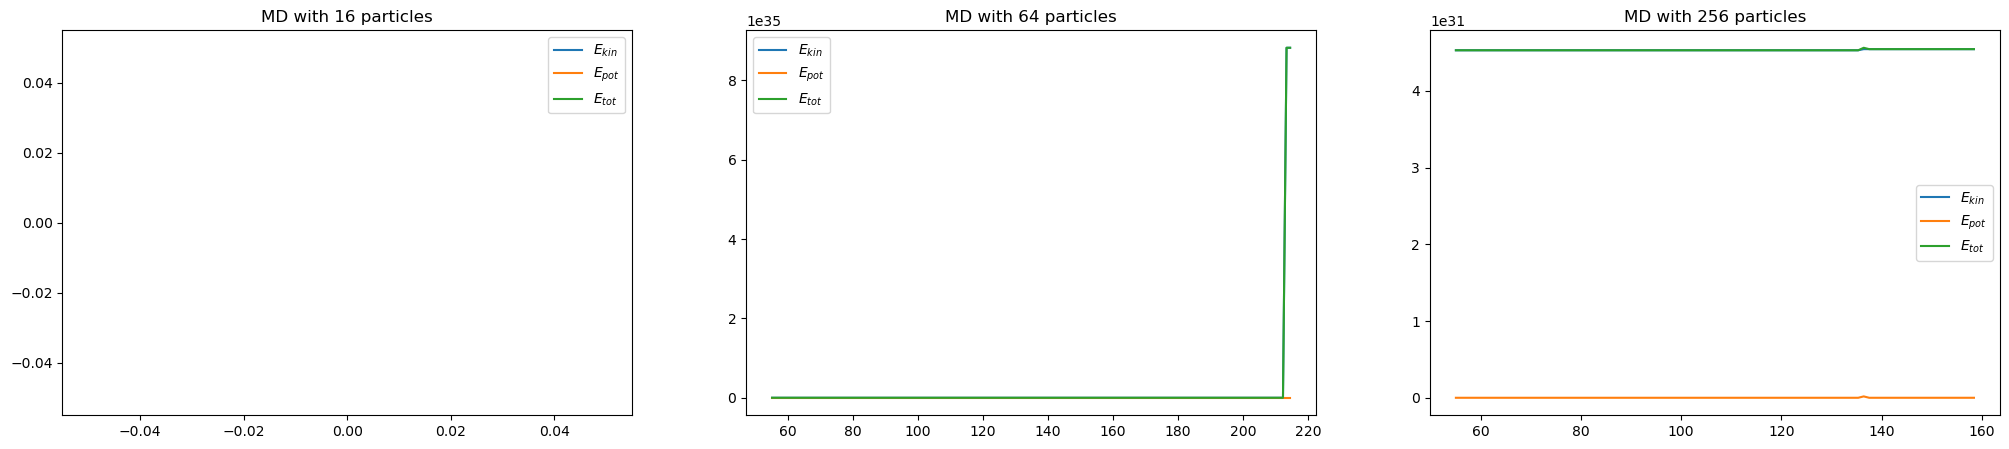

In [6]:
from tqdm.notebook import tqdm

steps = 1000
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
for i, md in enumerate(mds):
    Ekin = np.zeros(steps)
    Epot = np.zeros(steps)
    ticks = np.zeros(steps)
    for j in tqdm(range(steps)):
        observables = md.measure(H, 10)
        Ekin[j] = observables["Ekin"]
        Epot[j] = observables["Epot"]
        ticks[j] = observables["t"]
        md.equilibrate(H, 100)
    ax[i].plot(ticks, Ekin, label=r"$E_{kin}$")
    ax[i].plot(ticks, Epot, label=r"$E_{pot}$")
    ax[i].plot(ticks, Ekin + Epot, label=r"$E_{tot}$")
    ax[i].legend()
    ax[i].set_title(f"MD with {md.N} particles")